# Sentiment Analysis on Twitter data

The data contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions: using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. We make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. We make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

**(a)** We first read in the tweet data. Read the data present in `train.csv` file. Then we do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: Since we are are using `open()`, we set `encoding='iso8859'`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install torchinfo

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

torch.use_deterministic_algorithms(False)  # to help make code deterministic
# torch.backends.cudnn.benchmark = False  # to help make code deterministic
np.random.seed(0)  # to help make code deterministic
torch.manual_seed(0)  # to help make code deterministic
random.seed(0)  # to help make code deterministic

%cd /content/drive/MyDrive/Unstructured_Data_Analytics/HW3/

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy, UDA_get_rnn_last_time_step_outputs

/content/drive/MyDrive/Unstructured_Data_Analytics/HW3


In [ ]:
import csv
from collections import Counter

file_path = './HW3-data/train.csv'


sentiment_counts = Counter({'0': 0, '1': 0})
train_dataset = []
try:
    with open(file_path, 'r', encoding='iso8859') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            sentiment = row[0]
            tweet_text = row[-1]
            train_dataset.append((tweet_text, sentiment,))

            if sentiment in ['0', '1']:
                sentiment_counts[sentiment] += 1


    print(f"Number of positive sentiment labels: {sentiment_counts['1']}")
    print(f"Number of negative sentiment labels: {sentiment_counts['0']}")

except Exception as e:
    print(f"An error occurred: {e}")

Number of positive sentiment labels: 800000
Number of negative sentiment labels: 800000


**(b)** Now we modify the LSTM code to work with this Twitter dataset. We can play with the learning rate and batch size so that the training gives reasonable increases in validation accuracy scores as we progress through epochs (leave the number of epochs at 10). What test accuracy are you able to achieve?

In [ ]:
proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size
print('# proper training data points:', proper_train_size)
print('# validation data points:', val_size)

# proper training data points: 1280000
# validation data points: 320000


In [ ]:
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [ ]:
proper_train_dataset[0]

("@damohopo hey what do you mean by suggesting @rudedoodle and i are targets? i may look like a water buffalo but that's just mean  x",
 '0')

In [ ]:
from torchtext.data import get_tokenizer

In [ ]:
tokenizer_cased = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
def tokenizer(text):
    return [token.lower() for token in tokenizer_cased(text)]

In [ ]:
proper_train_dataset_as_tokens_without_labels = [tokenizer(text) for text, label in proper_train_dataset]

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
from itertools import chain


all_tokens = list(chain.from_iterable(proper_train_dataset_as_tokens_without_labels))

common_tokens = Counter(all_tokens).most_common(1000)

def yield_tokens():
    for word, _ in common_tokens:
        yield [word]

vocab = build_vocab_from_iterator(yield_tokens(),
                                  specials=["<unk>"],
                                  max_tokens=1000)

vocab.set_default_index(vocab['<unk>'])

In [ ]:
proper_train_encoded = [vocab(tokens) for tokens in proper_train_dataset_as_tokens_without_labels]


In [ ]:
proper_train_labels = [int(label) for text, label in proper_train_dataset]

In [ ]:
val_encoded = [vocab(tokenizer(text)) for text, label in val_dataset]

In [ ]:
val_labels = [int(label) for text, label in val_dataset]


In [ ]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

In [ ]:
from torchtext.vocab import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:39<00:00, 10124.86it/s]


In [ ]:
embedding_matrix = torch.zeros(len(vocab), pretrained_embedding.dim)
for i, token in enumerate(vocab.lookup_tokens(range(len(vocab)))):
    embedding_matrix[i] = pretrained_embedding[token]

In [ ]:
class EmbeddingLSTMLinearModel(nn.Module):
    def __init__(self, embedding_matrix, num_lstm_output_nodes, num_final_output_nodes):
        super().__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm_layer = nn.LSTM(embedding_matrix.shape[1], num_lstm_output_nodes)
        self.linear_layer = nn.Linear(num_lstm_output_nodes, num_final_output_nodes)

    def forward(self, text_encodings, lengths):
        embeddings = self.embedding_layer(text_encodings)

        rnn_last_time_step_outputs = UDA_get_rnn_last_time_step_outputs(embeddings, lengths, self.lstm_layer)

        return self.linear_layer(rnn_last_time_step_outputs)

In [ ]:
simple_lstm_model = EmbeddingLSTMLinearModel(embedding_matrix, 32, 2)

In [ ]:
summary(simple_lstm_model,
        input_data=[torch.zeros((7, 5), dtype=torch.long),
                    torch.tensor([3, 2, 5, 1, 7], dtype=torch.long)])

Layer (type:depth-idx)                   Output Shape              Param #
EmbeddingLSTMLinearModel                 [5, 2]                    --
├─Embedding: 1-1                         [7, 5, 100]               (100,000)
├─LSTM: 1-2                              [18, 32]                  17,152
├─Linear: 1-3                            [5, 2]                    66
Total params: 117,218
Trainable params: 17,218
Non-trainable params: 100,000
Total mult-adds (M): 10.58
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.47
Estimated Total Size (MB): 0.50

  0%|          | 0/10 [00:00<?, ?it/s]

  Proper training accuracy: 0.7947
  Validation accuracy: 0.7924


 10%|█         | 1/10 [04:02<36:22, 242.50s/it]

  Proper training accuracy: 0.8022
  Validation accuracy: 0.7992


 20%|██        | 2/10 [08:09<32:39, 244.97s/it]

  Proper training accuracy: 0.8048
  Validation accuracy: 0.8011


 30%|███       | 3/10 [12:01<27:54, 239.22s/it]

  Proper training accuracy: 0.8049
  Validation accuracy: 0.8008


 40%|████      | 4/10 [15:51<23:33, 235.63s/it]

  Proper training accuracy: 0.8096
  Validation accuracy: 0.8044


 50%|█████     | 5/10 [19:44<19:33, 234.76s/it]

  Proper training accuracy: 0.8093
  Validation accuracy: 0.8037


 60%|██████    | 6/10 [23:37<15:35, 233.96s/it]

  Proper training accuracy: 0.8102
  Validation accuracy: 0.8035


 70%|███████   | 7/10 [27:29<11:39, 233.24s/it]

  Proper training accuracy: 0.8120
  Validation accuracy: 0.8054


 80%|████████  | 8/10 [31:23<07:46, 233.46s/it]

  Proper training accuracy: 0.8126
  Validation accuracy: 0.8057


 90%|█████████ | 9/10 [35:16<03:53, 233.42s/it]

  Proper training accuracy: 0.8122
  Validation accuracy: 0.8061


100%|██████████| 10/10 [39:08<00:00, 234.84s/it]


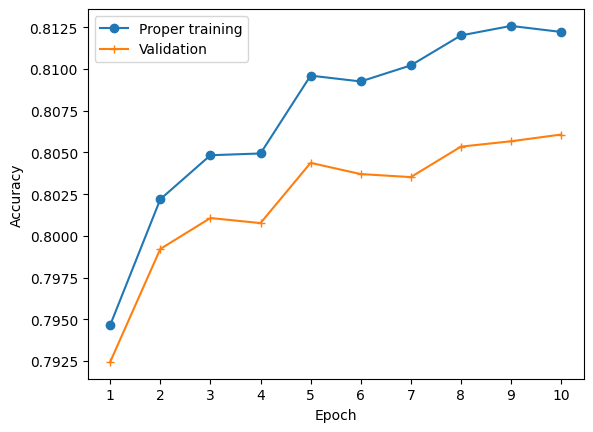

In [ ]:
num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 128  # during optimization, how many training data to use at each step
learning_rate = 0.001  # during optimization, how much we nudge our solution at each step

proper_train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               rnn=True,
                               save_epoch_checkpoint_prefix='./saved_model_checkpoints')

UDA_plot_train_val_accuracy_vs_epoch(proper_train_accuracies, val_accuracies)

In [ ]:
import csv
from collections import Counter

file_path = './HW3-data/test.csv'


sentiment_counts = Counter({'0': 0, '1': 0})
test_dataset = []
try:
    with open(file_path, 'r', encoding='iso8859') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            sentiment = row[0]
            tweet_text = row[-1]
            test_dataset.append((tweet_text, sentiment,))

            if sentiment in ['0', '1']:
                sentiment_counts[sentiment] += 1


    print(f"Number of positive sentiment labels: {sentiment_counts['1']}")
    print(f"Number of negative sentiment labels: {sentiment_counts['0']}")

except Exception as e:
    print(f"An error occurred: {e}")

Number of positive sentiment labels: 182
Number of negative sentiment labels: 316


In [ ]:
test_encoded = [vocab(tokenizer(text)) for text, label in test_dataset]

In [ ]:
test_labels = [int(label) for text, label in test_dataset]

In [ ]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       rnn=True)

In [ ]:
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.6385542168674698
